# 0. Описание задачи

Для освоения методов машинного обучения будем использовать базу данных интернет-магазина Sephora - ритейлера косметики и уходовых средств сегментов миддл и люкс. Будем пытаться предсказать рейтинг товара на основе цены, ингредиентов и других признаков. В датасете изначально 21 признак, но не все они влияют на рейтинг продукта (из личного опыта):

* category - категория на сайте
* brand - марка продукта 
* rating - средняя оценка пользователей (от 0 до 5 с шагом 0.5)
* love - сколько раз добавили в список желаемого
* price - цена (в долларах США)
* ingredients - состав
* limited_edition - ограниченный тираж
* limited_time_offer - доступно для покупки в течение ограниченного времени


Эти признаки необходимо оставить, так как они напрямую влияют на рейтинг продукта. Состав - текстовый признак, и его нельзя разбить на категории, так как количество возможных ингредиентов очень большое, и ключевую роль играют далеко не все компоненты. Поэтому попробуем выделить из каждого состава важнейшие ингредиенты и сделать уже их категориальными признаками. 


* name - название производителя
* ID - ID продукта на сайте 
* number of reviews - количество оценок
* value_price - цена с учетом скидки
* URL - ссылка на страницу продукта
* MarketingFlags - флаг для признаков exclusive, online_only
* MarketingFlags_content
* options - можно ли выбрать оттенок и так далее
* details - доступные детали
* how_to_use - инструкция
* online_only - можно купить только через сайт
* exclusive - можно купить только в этом магазине

Эти же признаки не должны оказывать сильного влияния на рейтинг продукта


# 1. и 2. Исходные данные и описательная статистика

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

Исходный датафрейм

In [51]:
url = 'sephora_website_dataset.csv'
data = pd.read_csv(url)
data.tail()

,id,brand,category,name,size,rating,number_of_reviews,love,price,value_price,...,MarketingFlags,MarketingFlags_content,options,details,how_to_use,ingredients,online_only,exclusive,limited_edition,limited_time_offer
9163,2208502,SEPHORA COLLECTION,Face Masks,The Rose Gold Mask,no size,2.0,15,6200,6.0,6.0,...,True,limited edition · exclusive,no options,What it is: A limited-edition- nurturing and h...,Suggested Usage:-Unfold the mask.-Apply the ma...,-Rose Quartz Extract: Hydrates dry skin. Aqua...,0,1,1,0
9164,2298909,SEPHORA COLLECTION,Lip Sets,Give Me Some Sugar Colorful Gloss Balm Set,3 x 0.32 oz/ 9 g,0.0,0,266,15.0,27.0,...,True,exclusive,no options,What it is: A set of three bestselling Colorfu...,Suggested Usage:-Apply directly to lips using ...,Colorful Gloss Balm Wanderlust: Hydrogenated P...,0,1,0,0
9165,2236750,SEPHORA COLLECTION,Tinted Moisturizer,Weekend Warrior Tone Up Cream,0.946 oz/ 28 mL,0.0,0,445,16.0,16.0,...,True,exclusive,no options,What it is: A weightless complexion booster- i...,Suggested Usage:-Use this product as the last ...,Aqua (Water)- Dimethicone- Isohexadecane- Poly...,0,1,0,0
9166,50,SEPHORA COLLECTION,no category,Gift Card,no size,5.0,46,0,50.0,50.0,...,False,0,no options,What it is:- Available in denominations of $10...,no instructions,unknown,0,0,0,0
9167,304,SEPHORA COLLECTION,no category,Happy Birthday Gift Card,no size,0.0,0,0,50.0,50.0,...,False,0,no options,What it is:\n- Available in denominations of $...,no instructions,unknown,0,0,0,0


Информация о данных:

In [4]:
data.describe()

,id,rating,number_of_reviews,love,price,value_price,online_only,exclusive,limited_edition,limited_time_offer
count,9.168000e+03,9168.000000,9168.000000,9.168000e+03,9168.000000,9168.00000,9168.000000,9168.000000,9168.000000,9168.000000
mean,1.962952e+06,3.990020,282.139180,1.627859e+04,50.063237,51.82359,0.234839,0.264725,0.091841,0.000327
std,3.859714e+05,1.007707,890.642028,4.260651e+04,47.164989,49.45902,0.423921,0.441211,0.288817,0.018087
min,5.000000e+01,0.000000,0.000000,0.000000e+00,2.000000,2.00000,0.000000,0.000000,0.000000,0.000000
25%,1.819453e+06,4.000000,10.000000,1.600000e+03,24.000000,25.00000,0.000000,0.000000,0.000000,0.000000
50%,2.072354e+06,4.000000,46.000000,4.800000e+03,35.000000,35.00000,0.000000,0.000000,0.000000,0.000000
75%,2.230591e+06,4.500000,210.000000,1.380000e+04,59.000000,60.00000,0.000000,1.000000,0.000000,0.000000
max,2.359685e+06,5.000000,19000.000000,1.300000e+06,549.000000,549.00000,1.000000,1.000000,1.000000,1.000000


Средний рейтинг - 4, средняя цена - 50 долларов, минимальная - 2, максимальная - 5 

Матрица корреляции:

<AxesSubplot:>

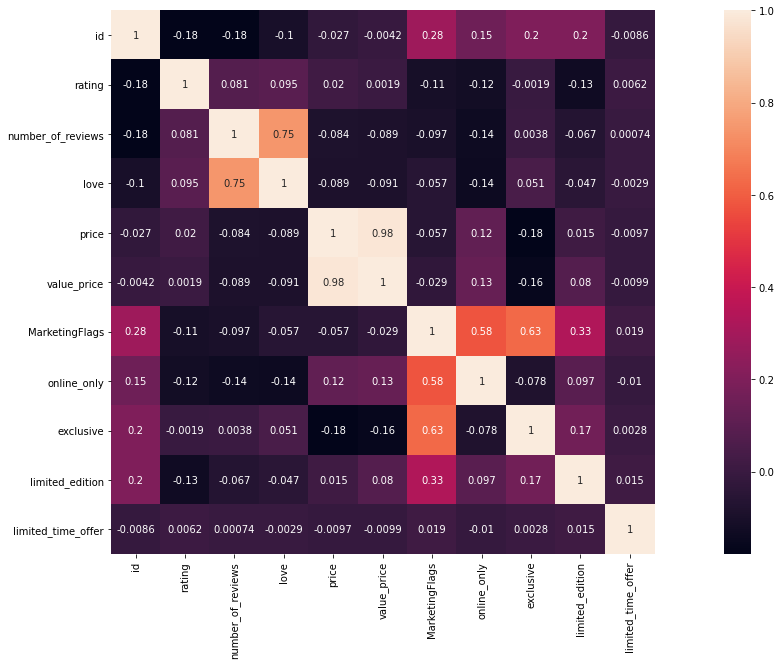

In [5]:
correlation = data.corr()
plt.figure(figsize=(25, 10))
sns.heatmap(correlation, square=True, annot=True, cmap='rocket')

Сильной корреляции почти не наблюдается - только у признаков MarketingFlag и признаков, соответствующих этому индикатору, а также у цены и той же цены с учетом скидки. У рейтинга слабая корреляция со всеми признаками

Диаграммы рассеивания для некоторых признаков

Text(0.5, 1.0, 'Зависимость рейтинга от цены')

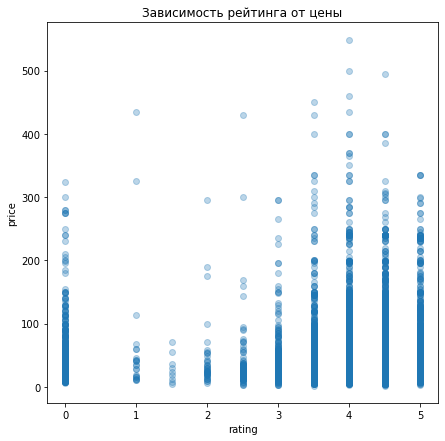

In [6]:
plt.figure(figsize=(7, 7))
plt.scatter(data['rating'], data['price'], alpha = 0.3, )
plt.xlabel('rating')
plt.ylabel('price')
plt.title('Зависимость рейтинга от цены')

Ситуация понятная - у многих продуктов еще просто нет рейтинга, никто их не оценивал. Преобладают оценки 3 и выше, ожидаемо для косметики среднего и выше ценового сегмента.

Text(0.5, 1.0, 'Зависимость количества людей, добавивших товар в список желаемого, от цены')

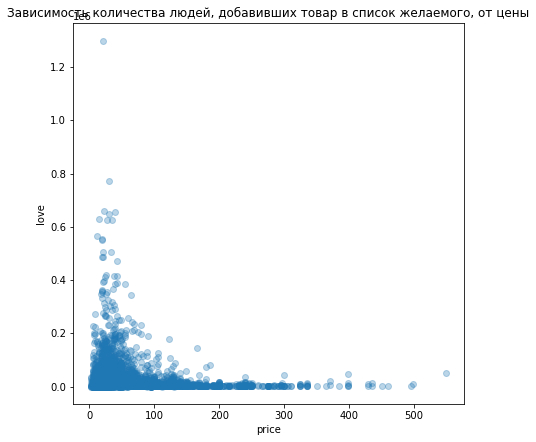

In [7]:
plt.figure(figsize=(7, 7))
plt.scatter(data['price'], data['love'], alpha = 0.3, )
plt.xlabel('price')
plt.ylabel('love')
plt.title('Зависимость количества людей, добавивших товар в список желаемого, от цены')

Чем дешевле товар, тем он популярнее в качестве планируемой покупки, также заметен выброс в левом верхнем углу диаграммы.

Text(0.5, 1.0, 'Зависимость количества людей, добавивших товар в список желаемого, от рейтинга')

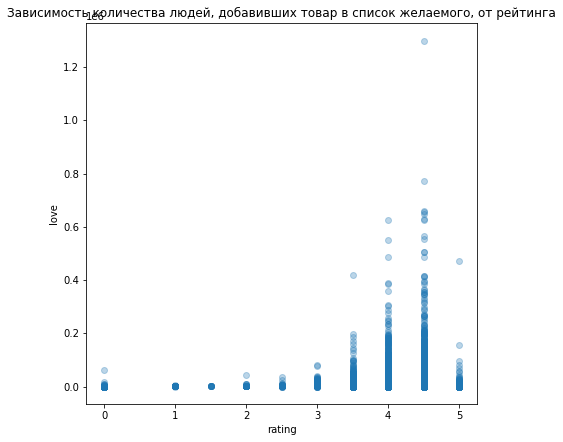

In [8]:
plt.figure(figsize=(7, 7))
plt.scatter(data['rating'], data['love'], alpha = 0.3, )
plt.xlabel('rating')
plt.ylabel('love')
plt.title('Зависимость количества людей, добавивших товар в список желаемого, от рейтинга')

Можно говорить, что покупатели присматриваются к товарам с высокой оценкой.

Text(0.5, 1.0, 'Зависимость числа отзывов от цены')

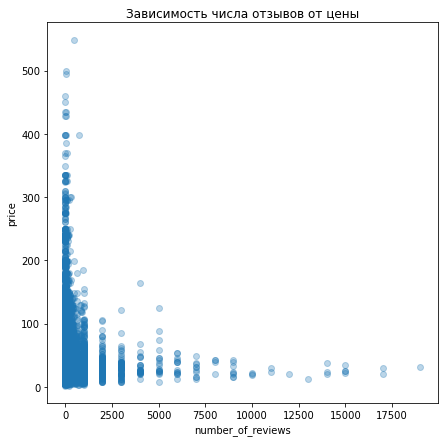

In [9]:
plt.figure(figsize=(7, 7))
plt.scatter(data['number_of_reviews'], data['price'], alpha = 0.3, )
plt.xlabel('number_of_reviews')
plt.ylabel('price')
plt.title('Зависимость числа отзывов от цены')

В среднем оставляют менее 2000 оценок, дорогие продукты оценивают реже (соответственно покупают реже).

# 3. Работа с пропущенными значениями

In [161]:
data.isna().sum()

id                        0
brand                     0
category                  0
name                      0
size                      0
rating                    0
number_of_reviews         0
love                      0
price                     0
value_price               0
URL                       0
MarketingFlags            0
MarketingFlags_content    0
options                   0
details                   0
how_to_use                0
ingredients               0
online_only               0
exclusive                 0
limited_edition           0
limited_time_offer        0
dtype: int64

Пропущенных числовых значений нет. Но есть товары без рейтинга!

In [208]:
Counter(data['rating'])

Counter({4.0: 2853,
         4.5: 3527,
         3.5: 1051,
         5.0: 872,
         3.0: 308,
         0.0: 398,
         2.5: 88,
         2.0: 39,
         1.0: 23,
         1.5: 9})

In [52]:
for i in range(len(data)):
    if data['rating'][i] == 0.0:
        data=data.drop(i, axis=0)
Counter(data['rating'])

Counter({4.0: 2853,
         4.5: 3527,
         3.5: 1051,
         5.0: 872,
         3.0: 308,
         2.5: 88,
         2.0: 39,
         1.0: 23,
         1.5: 9})

In [53]:
data=data.set_index(np.array(range(len(data))))
data

,id,brand,category,name,size,rating,number_of_reviews,love,price,value_price,...,MarketingFlags,MarketingFlags_content,options,details,how_to_use,ingredients,online_only,exclusive,limited_edition,limited_time_offer
0,2218774,Acqua Di Parma,Fragrance,Blu Mediterraneo MINIATURE Set,5 x 0.16oz/5mL,4.0,4,3002,66.0,75.0,...,True,online only,no options,This enchanting set comes in a specially handc...,Suggested Usage:-Fragrance is intensified by t...,Arancia di Capri Eau de Toilette: Alcohol Dena...,1,0,0,0
1,2044816,Acqua Di Parma,Cologne,Colonia,0.7 oz/ 20 mL,4.5,76,2700,66.0,66.0,...,True,online only,- 0.7 oz/ 20 mL Spray - 1.7 oz/ 50 mL Eau d...,An elegant timeless scent filled with a fresh-...,no instructions,unknown,1,0,0,0
2,1417567,Acqua Di Parma,Perfume,Arancia di Capri,5 oz/ 148 mL,4.5,26,2600,180.0,180.0,...,True,online only,- 1oz/30mL Eau de Toilette - 2.5 oz/ 74 mL E...,Fragrance Family: Fresh Scent Type: Fresh Citr...,no instructions,Alcohol Denat.- Water- Fragrance- Limonene- Li...,1,0,0,0
3,1417617,Acqua Di Parma,Perfume,Mirto di Panarea,2.5 oz/ 74 mL,4.5,23,2900,120.0,120.0,...,True,online only,- 1 oz/ 30 mL Eau de Toilette Spray - 2.5 oz/...,Panarea near Sicily is an an island suspended ...,no instructions,unknown,1,0,0,0
4,2218766,Acqua Di Parma,Fragrance,Colonia Miniature Set,5 x 0.16oz/5mL,3.5,2,943,72.0,80.0,...,True,online only,no options,The Colonia Miniature Set comes in an iconic A...,Suggested Usage:-Fragrance is intensified by t...,Colonia: Alcohol Denat.- Water- Fragrance- Lim...,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8765,2149847,SEPHORA COLLECTION,Bath Soaks & Bubble Bath,Fizzing Bath Star Mini - Surprise Flowers,0.53oz/15g,3.5,11,2100,2.0,2.0,...,True,exclusive · online only,no options,What it is: A fizzing star that dissolves int...,Suggested Usage:-Place the fizzing star in the...,Sodium Bicarbonate- Citric Acid- CI 77891 (Tit...,1,1,0,0
8766,1601111,SEPHORA COLLECTION,Brush Sets,Face the Day: Full Face Brush Set,no size,3.5,62,32900,49.0,95.0,...,True,limited edition · exclusive,no options,What it is:\nA six-piece brush set designed to...,no instructions,unknown,0,1,1,0
8767,2149839,SEPHORA COLLECTION,Scrub & Exfoliants,Exfoliating Body Granita Scrub - Surprise Flowers,8.45oz/250mL,3.5,39,6900,8.0,8.0,...,True,exclusive · online only,no options,What it is: An indulgent- yet gentle exfoliat...,Suggested Usage:-Apply to wet skin.-Massage in...,Water- Glycerin- Cellulose Acetate- Sodium Lau...,1,1,0,0
8768,2208502,SEPHORA COLLECTION,Face Masks,The Rose Gold Mask,no size,2.0,15,6200,6.0,6.0,...,True,limited edition · exclusive,no options,What it is: A limited-edition- nurturing and h...,Suggested Usage:-Unfold the mask.-Apply the ma...,-Rose Quartz Extract: Hydrates dry skin. Aqua...,0,1,1,0


# 4. Обработка категориальных признаков (и всех данных)

Удалим столбцы, не влияющие или слабо влияющие на рейтинг продукта

In [54]:
data = data.drop([
'name',
'id',
'number_of_reviews', #поскольку задача предсказать рейтинг у нового продукта, это ни к чему
'value_price',
'URL',
'MarketingFlags',
'MarketingFlags_content',
'options',
'details',
'how_to_use',
'online_only',
'exclusive', 'size'], axis = 1)

In [55]:
brands = dict(Counter(data['brand']))
brands

{'Acqua Di Parma': 29,
 'AERIN': 21,
 'Aether Beauty': 6,
 'Algenist': 51,
 'Alpha-H': 13,
 'alpyn beauty': 5,
 'ALTERNA Haircare': 42,
 'amika': 63,
 'AMOREPACIFIC': 31,
 'Anastasia Beverly Hills': 68,
 'Anthony': 14,
 'Antonym': 3,
 'Aquis': 5,
 'Armani Beauty': 55,
 'The Art of Shaving': 15,
 'Artis': 19,
 'Artist Couture': 8,
 'Atelier Cologne': 44,
 'BALENCIAGA': 2,
 'bareMinerals': 57,
 'Beachwaver': 1,
 'The Beauty Chef': 7,
 'BeautyBio': 24,
 'beautyblender': 26,
 'BECCA': 35,
 'belif': 28,
 'Benefit Cosmetics': 90,
 'BERDOUES': 14,
 'Bésame Cosmetics': 2,
 'Better Not Younger': 14,
 'Bio Ionic': 12,
 'Biossance': 21,
 'Bite Beauty': 12,
 'bkr': 1,
 'Black Up': 5,
 'Blinc': 3,
 'Bobbi Brown': 74,
 'boscia': 20,
 'Briogeo': 47,
 'Bumble and bumble': 101,
 'BURBERRY': 25,
 'Buxom': 6,
 'BVLGARI': 24,
 'By Rosie Jane': 20,
 'Calvin Klein': 9,
 'Capri Blue': 12,
 'Carolina Herrera': 12,
 'Caudalie': 54,
 'Cellu-cup': 1,
 'CHANEL': 52,
 'Charlotte Tilbury': 73,
 'Chloé': 21,
 'Chris

Названий много, тем не менее, бренд для задачи очень важен. Поскольку он номинальный, нельзя применить label encoding. Так как различных наименований около 300, One-hot encoding тоже будет не лучшим решением, так как некоторые бренды встречаются один раз или около того (а такие значения важны: предсказать рейтинг у неизвестной марки более актуальная задача, чем, например, у именитого бренда, с ним и так всё понятно). Поэтому заменим названия брендов в столбце на частоту, с которой они встречаются в датасете.

In [56]:
for i in range(len(data)):
    data['brand'][i] = brands[data['brand'][i]]

<ipython-input-56-b5483aca9230>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['brand'][i] = brands[data['brand'][i]]


In [57]:
data.head(20)

,brand,category,rating,love,price,ingredients,limited_edition,limited_time_offer
0,29,Fragrance,4.0,3002,66.0,Arancia di Capri Eau de Toilette: Alcohol Dena...,0,0
1,29,Cologne,4.5,2700,66.0,unknown,0,0
2,29,Perfume,4.5,2600,180.0,Alcohol Denat.- Water- Fragrance- Limonene- Li...,0,0
3,29,Perfume,4.5,2900,120.0,unknown,0,0
4,29,Fragrance,3.5,943,72.0,Colonia: Alcohol Denat.- Water- Fragrance- Lim...,0,0
5,29,Perfume,4.5,2600,180.0,unknown,0,0
6,29,Perfume,4.5,5000,210.0,unknown,0,0
7,29,Cologne,5.0,719,120.0,Alcohol Denat.- Water- Fragrance- Limonene- Hy...,0,0
8,29,Body Mist & Hair Mist,4.0,800,58.0,Alcohol Denat.- Water- Fragrance- Polyquaterni...,0,0
9,29,Perfume,3.0,2100,58.0,unknown,0,0


Категория товара может оказывать влияние на рейтинг продукта: если мы знаем, что это продукт для бровей от известной компании (специализирующейся на этом) с хорошими оценками и высокой ценой - можно гарантировать высокий рейтинг. Однако какие-нибудь уходовые средства от них же не будут такими же удачными. Поэтому из множества различных категорий товаров выделим продукты для ухода, для макияжа, продукты для волос, для тела и ванны, инструменты и кисточки, всё остальное. 

In [58]:
cat = Counter(data['category'])
cat

Counter({'Fragrance': 10,
         'Cologne': 154,
         'Perfume': 656,
         'Body Mist & Hair Mist': 29,
         'Body Lotions & Body Oils': 108,
         'Body Sprays & Deodorant': 18,
         'Perfume Gift Sets': 104,
         'Rollerballs & Travel Size': 220,
         'Lip Balm & Treatment': 81,
         'Lotions & Oils': 91,
         'Eye Palettes': 199,
         'Highlighter': 161,
         'Cheek Palettes': 30,
         'Lipstick': 188,
         'Face Serums': 378,
         'Moisturizers': 442,
         'Value & Gift Sets': 316,
         'Eye Creams & Treatments': 189,
         'Face Sunscreen': 74,
         'Lip Balms & Treatments': 78,
         'Face Masks': 226,
         'Face Wash & Cleansers': 245,
         'Decollete & Neck Creams': 10,
         'Face Oils': 83,
         'Hand Cream & Foot Cream': 26,
         'Face Primer': 143,
         'Color Correct': 10,
         'Mists & Essences': 80,
         'Tinted Moisturizer': 16,
         'Concealer': 100,
         '

In [59]:
len(data['category'].unique())

143

In [60]:
new_categories = {
    'skincare' : ['Lip Balm & Treatment', 'Face Serums', 'Moisturizers', 'Eye Creams & Treatments',
         'Face Sunscreen',
         'Lip Balms & Treatments', 'Face Masks',
         'Face Wash & Cleansers',       
         'Face Oils', 'Tinted Moisturizer', 'Facial Peels', 'Exfoliators', 'Toners', 'Sheet Masks', 'Skincare', 'Face Wash',
            'Skincare Sets', 'Moisturizer & Treatments', 'Eye Cream', 'Sunscreen', 'Face Sets', 'Anti-Aging', 'Eye Masks',
                 'Night Creams',  'Blemish & Acne Treatments',  'Lip Sunscreen', 'Lip Treatments', 'For Face',] ,
    
    'body_bath' : ['Body Lotions & Body Oils',
         'Body Sprays & Deodorant', 'Lotions & Oils', 'Decollete & Neck Creams', 'Hand Cream & Foot Cream',
                  'Body Sunscreen', 'Body Products', 'Shaving', 'Aftershave', 'Bath & Shower', 'Deodorant & Antiperspirant',
         'Holistic Wellness', 'Scrub & Exfoliants',
         'Cellulite & Stretch Marks', 'For Body',
         'Self Tanners', 'Body Wash & Shower Gel', 'Teeth Whitening',
         'Bath Soaks & Bubble Bath', 'Bath & Body', 'Deodorant for Men',
         'After Sun Care', 'Wellness',
         'Hair Removal', 'Body Moisturizers',
         'Hair Removal & Shaving', 'Spa Tools',],
    'makeup' : ['Eye Palettes',
         'Highlighter',
         'Cheek Palettes',
         'Lipstick', 'Face Primer', 'Color Correct', 'Concealer', 'Eyebrow',
         'Mascara',
         'Foundation', 'Setting Spray & Powder',
         'Contour',
         'Tweezers & Eyebrow Tools',
         'Eyeshadow',
         'Lip Gloss',
         'False Eyelashes',
         'Bronzer',
         'Eyeliner',
         'Eye Primer',
         'Eye Sets', 'Liquid Lipstick',
         'Makeup', 'Lip Liner', 'Lip Stain',
         'Lip Sets', 'Lip Plumper', 'Makeup Palettes', 'BB & CC Cream', 'BB & CC Creams', 'Blush',],
    
    'fragrance' :['Cologne',
         'Perfume',        
         'Perfume Gift Sets', 'Cologne Gift Sets', 'Candles & Home Scents', 'Candles', 'Diffusers', 'Body Mist & Hair Mist', 
                 'Mists & Essences', 'Fragrance',],
    
    'hair' : ['Conditioner',
         'Shampoo',
         'Hair Styling Products',
         'Scalp & Hair Treatments',
         'Hair Masks',
         'Hair Spray',
         'Hair Oil',
         'Hair Primers',
         'Dry Shampoo',
         'Hair',
         'Hair Thinning & Hair Loss',
         'Color Care', 'Hair Styling & Treatments', 'Curls & Coils', 'Shampoo & Conditioner','Hair Products', 'Leave-In Conditioner',],
    'tools' : ['Curling Irons', 'Hair Straighteners & Flat Irons', 'Hair Dryers', 'Hair Brushes & Combs', 'High Tech Tools',
            'Eye Brushes',
         'Face Brushes',
         'Sponges & Applicators',
         'Mirrors & Sharpeners',
         'Brush Sets',
         'Brush Cleaners',
         'Lip Brushes',
        'Facial Rollers',
            'Face Wipes',
         'Makeup & Travel Cases',
              'Makeup Removers',
         'Blotting Papers',
              'Nail',
              'Facial Cleansing Brushes',
         'Cleansing Brushes',
              'Eyelash Curlers',
         'Makeup Bags & Travel Cases',
              'Powder Brush',
         'Lid Shadow Brush'],
    'other' : ['Hair Accessories', 'no category',
         'Rollerballs & Travel Size',  'Value & Gift Sets',
         'Mini Size',
         'Beauty Supplements',  'Accessories',
         ],
}

In [61]:


for i in range(len(data)):
    for j in new_categories.items():
        if data['category'][i] in j[1]:
            data['category'][i] = j[0]
            i+=1

<ipython-input-61-c03c72bffdef>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['category'][i] = j[0]


In [62]:
data['category']

0       fragrance
1       fragrance
2       fragrance
3       fragrance
4       fragrance
          ...    
8765    body_bath
8766        tools
8767    body_bath
8768     skincare
8769        other
Name: category, Length: 8770, dtype: object

In [63]:
data.head(20)

,brand,category,rating,love,price,ingredients,limited_edition,limited_time_offer
0,29,fragrance,4.0,3002,66.0,Arancia di Capri Eau de Toilette: Alcohol Dena...,0,0
1,29,fragrance,4.5,2700,66.0,unknown,0,0
2,29,fragrance,4.5,2600,180.0,Alcohol Denat.- Water- Fragrance- Limonene- Li...,0,0
3,29,fragrance,4.5,2900,120.0,unknown,0,0
4,29,fragrance,3.5,943,72.0,Colonia: Alcohol Denat.- Water- Fragrance- Lim...,0,0
5,29,fragrance,4.5,2600,180.0,unknown,0,0
6,29,fragrance,4.5,5000,210.0,unknown,0,0
7,29,fragrance,5.0,719,120.0,Alcohol Denat.- Water- Fragrance- Limonene- Hy...,0,0
8,29,fragrance,4.0,800,58.0,Alcohol Denat.- Water- Fragrance- Polyquaterni...,0,0
9,29,fragrance,3.0,2100,58.0,unknown,0,0


Теперь различных категорий стало значительно меньше, и можно применить кодирование по столбцам для номинальных признаков 

In [64]:
onehot = pd.get_dummies(data['category'])
data = data.drop('category', axis=1)
data = data.join(onehot)

In [65]:
data.head(20)

,brand,rating,love,price,ingredients,limited_edition,limited_time_offer,body_bath,fragrance,hair,makeup,other,skincare,tools
0,29,4.0,3002,66.0,Arancia di Capri Eau de Toilette: Alcohol Dena...,0,0,0,1,0,0,0,0,0
1,29,4.5,2700,66.0,unknown,0,0,0,1,0,0,0,0,0
2,29,4.5,2600,180.0,Alcohol Denat.- Water- Fragrance- Limonene- Li...,0,0,0,1,0,0,0,0,0
3,29,4.5,2900,120.0,unknown,0,0,0,1,0,0,0,0,0
4,29,3.5,943,72.0,Colonia: Alcohol Denat.- Water- Fragrance- Lim...,0,0,0,1,0,0,0,0,0
5,29,4.5,2600,180.0,unknown,0,0,0,1,0,0,0,0,0
6,29,4.5,5000,210.0,unknown,0,0,0,1,0,0,0,0,0
7,29,5.0,719,120.0,Alcohol Denat.- Water- Fragrance- Limonene- Hy...,0,0,0,1,0,0,0,0,0
8,29,4.0,800,58.0,Alcohol Denat.- Water- Fragrance- Polyquaterni...,0,0,0,1,0,0,0,0,0
9,29,3.0,2100,58.0,unknown,0,0,0,1,0,0,0,0,0


Так как в составы продуктов, представленных на сайте, могут входить совершенно разнообразные компоненты, причем целым списком, сделать их категориальными признаками тяжело, удалим их из датасета для простоты рассмотрения.

In [66]:
data = data.drop('ingredients', axis=1)

In [67]:
data

,brand,rating,love,price,limited_edition,limited_time_offer,body_bath,fragrance,hair,makeup,other,skincare,tools
0,29,4.0,3002,66.0,0,0,0,1,0,0,0,0,0
1,29,4.5,2700,66.0,0,0,0,1,0,0,0,0,0
2,29,4.5,2600,180.0,0,0,0,1,0,0,0,0,0
3,29,4.5,2900,120.0,0,0,0,1,0,0,0,0,0
4,29,3.5,943,72.0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8765,465,3.5,2100,2.0,0,0,1,0,0,0,0,0,0
8766,465,3.5,32900,49.0,1,0,0,0,0,0,0,0,1
8767,465,3.5,6900,8.0,0,0,1,0,0,0,0,0,0
8768,465,2.0,6200,6.0,1,0,0,0,0,0,0,1,0


In [68]:
data.dtypes

brand                  object
rating                float64
love                    int64
price                 float64
limited_edition         int64
limited_time_offer      int64
body_bath               uint8
fragrance               uint8
hair                    uint8
makeup                  uint8
other                   uint8
skincare                uint8
tools                   uint8
dtype: object

Поработаем с выбросами:

In [69]:
num_data = data.select_dtypes(include=['int', 'int64', 'float64'])
num_data

,rating,love,price,limited_edition,limited_time_offer
0,4.0,3002,66.0,0,0
1,4.5,2700,66.0,0,0
2,4.5,2600,180.0,0,0
3,4.5,2900,120.0,0,0
4,3.5,943,72.0,0,0
...,...,...,...,...,...
8765,3.5,2100,2.0,0,0
8766,3.5,32900,49.0,1,0
8767,3.5,6900,8.0,0,0
8768,2.0,6200,6.0,1,0


In [70]:
num_data.quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

,rating,love,price,limited_edition,limited_time_offer
0.005,2.0,0.00,6.0,0.0,0.0
0.010,2.5,0.00,6.0,0.0,0.0
0.050,3.0,409.45,12.0,0.0,0.0
0.100,3.5,756.90,16.0,0.0,0.0
0.500,4.5,5200.00,35.0,0.0,0.0
0.900,4.5,38500.00,98.0,0.0,0.0
0.950,5.0,67355.00,139.0,1.0,0.0
0.990,5.0,191010.00,240.0,1.0,0.0
0.995,5.0,272958.00,295.0,1.0,0.0


In [71]:
rows_to_drop = num_data[
    (num_data['price'] < num_data['price'].quantile(0.005)) | (num_data['price'] > num_data['price'].quantile(0.995)) | 
    (num_data['love'] < num_data['love'].quantile(0.005)) | (num_data['love'] > num_data['love'].quantile(0.995))].index
len(rows_to_drop)

128

Имеем 128 строк с выбросами, удалим их

In [72]:
data = data.drop(rows_to_drop, axis = 0)

In [73]:
data

,brand,rating,love,price,limited_edition,limited_time_offer,body_bath,fragrance,hair,makeup,other,skincare,tools
0,29,4.0,3002,66.0,0,0,0,1,0,0,0,0,0
1,29,4.5,2700,66.0,0,0,0,1,0,0,0,0,0
2,29,4.5,2600,180.0,0,0,0,1,0,0,0,0,0
3,29,4.5,2900,120.0,0,0,0,1,0,0,0,0,0
4,29,3.5,943,72.0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8764,465,4.0,4800,12.0,0,0,1,0,0,0,0,0,0
8766,465,3.5,32900,49.0,1,0,0,0,0,0,0,0,1
8767,465,3.5,6900,8.0,0,0,1,0,0,0,0,0,0
8768,465,2.0,6200,6.0,1,0,0,0,0,0,0,1,0


Посмотрим, какое соотношение классов в задаче

In [74]:
dict(Counter(data['rating']))

{4.0: 2820,
 4.5: 3470,
 3.5: 1034,
 5.0: 863,
 3.0: 304,
 2.5: 83,
 2.0: 39,
 1.0: 21,
 1.5: 8}

Классы несбалансированы, преобладают оценки продуктов 4 и 4.5, причём оценок 5 в несколько раз меньше, а оценок ниже 3 совсем мало в сравнении с общим числом объектов.

Для корректной работы классификатора переведём все значения y в целые числа:

In [75]:
data['rating'] = data['rating']*2

In [76]:
data[['rating']] = data[['rating']].astype(int)
data['rating']

0        8
1        9
2        9
3        9
4        7
        ..
8764     8
8766     7
8767     7
8768     4
8769    10
Name: rating, Length: 8642, dtype: int32

# 6. Обучающая и тестовая выборки

In [77]:
X=data.drop('rating', axis=1)
y=data['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3)

In [78]:
X_train

,brand,love,price,limited_edition,limited_time_offer,body_bath,fragrance,hair,makeup,other,skincare,tools
4518,35,3300,30.00,0,0,0,0,0,0,0,1,0
5034,98,36100,43.00,0,0,0,0,0,1,0,0,0
6991,465,12700,10.00,0,0,0,0,0,0,0,0,1
2874,26,402,19.99,0,0,0,0,0,0,0,1,0
3545,32,1800,25.00,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
487,44,915,275.00,0,0,0,1,0,0,0,0,0
5875,31,10400,65.00,0,0,0,0,0,0,0,1,0
7236,22,2200,24.00,0,0,1,0,0,0,0,0,0
956,47,12600,24.00,0,0,0,0,1,0,0,0,0


In [79]:
y_train

4518    8
5034    8
6991    8
2874    7
3545    7
       ..
487     9
5875    9
7236    9
956     8
2439    8
Name: rating, Length: 6049, dtype: int32

# 7. и 8. Классификатор ближайших соседей и его результаты

In [80]:
model = KNeighborsClassifier(n_neighbors=4)
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4)

In [81]:
y_train_predict = model.predict(X_train)
y_test_predict  = model.predict(X_test)

In [82]:
print('f1 на тренировочной выборке', f1_score(y_train, y_train_predict, average='weighted'))
print('f1 на тестовой выборке', f1_score(y_test, y_test_predict, average='weighted'))

f1 на тренировочной выборке 0.5794375907347054
f1 на тестовой выборке 0.33144994879662837


Судя по всему, модель недообучается

In [83]:
def best_results(model, params):
    pipeline=Pipeline(steps=[('scaler', StandardScaler()), ('model', model)])
    clf = GridSearchCV(pipeline, params, scoring='f1_weighted', refit=True, n_jobs=-1)
    #использовали метрику f1_weighted, поскольку это мультиклассовая задача
    return(clf)

In [84]:
model=KNeighborsClassifier()
clf=best_results(model, {'model__n_neighbors': list(range(2, 30))})
clf.fit(X_train, y_train)
preds=clf.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, preds), '\n', 'лучшие гиперпараметры: ', clf.best_params_)
print(classification_report(y_test, preds))
preds=clf.best_estimator_.predict(X_train)
print(confusion_matrix(y_train, preds), '\n', 'лучшие гиперпараметры: ', clf.best_params_)
print(classification_report(y_train, preds))

[[  0   0   0   0   0   0   3   2   1]
 [  0   0   0   0   0   0   0   1   0]
 [  0   0   0   0   0   0   3  11   1]
 [  0   0   0   0   1   2   8  10   4]
 [  0   0   0   0   0   9  38  47   5]
 [  0   0   0   0   2  10 155 160  10]
 [  0   0   0   0   0  24 319 495  22]
 [  0   0   0   0   2  18 349 602  28]
 [  0   0   0   0   1   7  65 140  38]] 
 лучшие гиперпараметры:  {'model__n_neighbors': 24}
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        15
           5       0.00      0.00      0.00        25
           6       0.00      0.00      0.00        99
           7       0.14      0.03      0.05       337
           8       0.34      0.37      0.35       860
           9       0.41      0.60      0.49       999
          10       0.35      0.15      0.21       251

    accuracy                           0.37      2593

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[   0    0    0    0    1    0    6    6    2]
 [   0    0    0    0    0    0    4    3    0]
 [   0    0    0    0    0    5    9   10    0]
 [   0    0    0    0    1    4   27   17    9]
 [   0    0    0    0    6   13   95   78   13]
 [   0    0    0    0    2   68  273  329   25]
 [   0    0    0    0    3   34  949  911   63]
 [   0    0    0    0    3   43  683 1680   62]
 [   0    0    0    0    1   22  154  314  121]] 
 лучшие гиперпараметры:  {'model__n_neighbors': 24}
              precision    recall  f1-score   support

           2       0.00      0.00      0.00        15
           3       0.00      0.00      0.00         7
           4       0.00      0.00      0.00        24
           5       0.00      0.00      0.00        58
           6       0.35      0.03      0.05       205
           7       0.36      0.10      0.15       697
           8       0.43      0.48      0.46      1960
           9       0.50      0.68      0.58      2471
          10       0.41    

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Происходит что-то странное:  2, 3, 4, 5  классы не были предсказаны вообще, результаты на тесте очень плохие.
На тренировочной выборке ситуация аналогичная, модель недообучается

# 9. Другие классификаторы

In [61]:
model=RandomForestClassifier()
clf=best_results(model, {'model__max_depth': list(range(2, 10)), 'model__n_estimators' : list(range(10, 200, 10))})
clf.fit(X_train, y_train)
preds=clf.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, preds), '\n', 'лучшие гиперпараметры: ', clf.best_params_)
print(classification_report(y_test, preds))

C:\anaconda\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[[  0   0   0   0   0   0   1   2   4]
 [  0   0   0   1   0   0   0   2   1]
 [  1   0   0   0   0   2   2   5   4]
 [  0   0   0   0   0   2   4  13   3]
 [  0   0   0   0   0   4  34  42  13]
 [  0   0   0   0   0   3  97 187  16]
 [  0   0   0   0   0   8 217 615  34]
 [  0   0   0   0   0  10 181 773  36]
 [  0   0   0   0   0   4  46 173  53]] 
 лучшие гиперпараметры:  {'model__max_depth': 9, 'model__n_estimators': 180}
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00        14
           5       0.00      0.00      0.00        22
           6       0.00      0.00      0.00        93
           7       0.09      0.01      0.02       303
           8       0.37      0.25      0.30       874
           9       0.43      0.77      0.55      1000
          10       0.32      0.19      0.24       276

    accuracy                

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
model=DecisionTreeClassifier()
clf=best_results(model, {'model__max_depth': list(range(2, 20))})
clf.fit(X_train, y_train)
preds=clf.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, preds), '\n','f1_weighted на тестовой выборке: ', clf.best_score_, '\n', 'лучшие гиперпараметры: ', clf.best_params_)
print(classification_report(y_test, preds))

C:\anaconda\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[[  0   0   0   0   0   0   0   3   4]
 [  0   0   0   0   0   0   0   2   2]
 [  0   0   0   0   0   2   5   5   2]
 [  0   0   0   0   1   1   5  12   3]
 [  0   0   0   0   1   2  33  46  11]
 [  0   0   0   1   2   8 106 170  16]
 [  0   0   0   0   8  22 261 553  30]
 [  0   0   0   1   7  23 293 639  37]
 [  0   0   1   1   7   6  63 156  42]] 
 f1_weighted на тестовой выборке:  0.36674348076151014 
 лучшие гиперпараметры:  {'model__max_depth': 8}
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00        14
           5       0.00      0.00      0.00        22
           6       0.04      0.01      0.02        93
           7       0.12      0.03      0.04       303
           8       0.34      0.30      0.32       874
           9       0.40      0.64      0.49      1000
          10       0.29      0.15      0.20       276



C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
model=GradientBoostingClassifier()
clf=best_results(model, {'model__n_estimators': list(range(50, 300, 50))})
clf.fit(X_train, y_train)
preds=clf.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, preds), '\n','f1_weighted на тестовой выборке: ', clf.best_score_, '\n', 'лучшие гиперпараметры: ', clf.best_params_)

C:\anaconda\lib\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


[[  0   0   0   0   0   1   0   1   5]
 [  0   0   0   1   0   0   1   1   1]
 [  2   0   0   0   0   0   4   2   6]
 [  0   0   0   1   1   4   3  10   3]
 [  0   0   0   0   0   9  30  40  14]
 [  1   0   0   2   7  21 107 145  20]
 [  0   0   2   2  10  30 302 490  38]
 [  1   0   1   1  10  24 255 657  51]
 [  3   0   2   1   3  10  45 150  62]] 
 f1_weighted на тестовой выборке:  0.38617925191997265 
 лучшие гиперпараметры:  {'model__n_estimators': 250}


И эта модель показала схожий результат. Возможно, дело в сильной несбалансированности классов при не очень большой выборке.

# 10. Попытка справиться с несбалансированностью классов

Случайный сэмплинг: пополнение выборки случайными копиями объектами, принадлежащими меньшинству(скорее всего, не принесёт содержательных результатов). Здесь все классы были приравнены между собой по количеству объектов. Попробуем те же модели:

In [64]:
#KNN
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

model=KNeighborsClassifier()
clf=best_results(model, {'model__n_neighbors': list(range(2, 10))})
clf.fit(X_resampled, y_resampled)
preds=clf.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, preds), clf.best_params_)
print(classification_report(y_test, preds))

[(2, 2470), (3, 2470), (4, 2470), (5, 2470), (6, 2470), (7, 2470), (8, 2470), (9, 2470), (10, 2470)]
[[  0   0   0   0   1   1   0   2   3]
 [  0   0   0   1   0   1   0   1   1]
 [  1   0   1   1   0   6   1   2   2]
 [  2   0   0   2   2   4   5   5   2]
 [  0   0   0   1   8  31  27  12  14]
 [  2   1   2   4  25  80 122  49  18]
 [  0   0   0  13  50 173 407 180  51]
 [  2   2   2   9  46 179 445 250  65]
 [  4   1   8   6  17  41  81  56  62]] 0.8360835856602341 {'model__n_neighbors': 2}
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         4
           4       0.08      0.07      0.07        14
           5       0.05      0.09      0.07        22
           6       0.05      0.09      0.07        93
           7       0.16      0.26      0.20       303
           8       0.37      0.47      0.41       874
           9       0.45      0.25      0.32      1000
          10   

In [65]:
#RandomForest
model=RandomForestClassifier()
clf=best_results(model, {'model__n_estimators': list(range(1, 300, 20)), 'model__max_depth': list(range(1, 15, 2))})
clf.fit(X_resampled, y_resampled)
preds=clf.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, preds), '\n', 'лучшие гиперпараметры: ', clf.best_params_)
print(classification_report(y_test, preds))

[[  0   0   0   0   1   1   1   0   4]
 [  0   0   0   1   0   1   0   0   2]
 [  1   0   0   1   0   3   2   2   5]
 [  0   0   0   2   1   7   0   2  10]
 [  0   0   0   2  13  22  23  12  21]
 [  1   0   3   5  29  52  90  70  53]
 [  0   0   1  14  38 134 281 305 101]
 [  0   0   1   8  40 121 288 422 120]
 [  3   0   0   7  23  30  31  64 118]] 
 лучшие гиперпараметры:  {'model__max_depth': 13, 'model__n_estimators': 241}
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00        14
           5       0.05      0.09      0.06        22
           6       0.09      0.14      0.11        93
           7       0.14      0.17      0.15       303
           8       0.39      0.32      0.35       874
           9       0.48      0.42      0.45      1000
          10       0.27      0.43      0.33       276

    accuracy               

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
#DecisionTree
model=DecisionTreeClassifier()
clf=best_results(model, {'model__max_depth': list(range(2, 20))})
clf.fit(X_resampled, y_resampled)
preds=clf.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, preds),'\n', 'лучшие гиперпараметры: ', clf.best_params_)
print(classification_report(y_test, preds))

[[  0   0   1   0   1   0   3   0   2]
 [  0   0   0   0   0   2   1   0   1]
 [  1   0   0   1   0   4   2   2   4]
 [  0   0   2   0   1   6   5   5   3]
 [  0   1   1   1   6  23  21  21  19]
 [  0   1   1   1  21  44  97  98  40]
 [  0   1   6  11  37 119 294 332  74]
 [  0   0   1   8  37 110 372 379  93]
 [  5   0   1   4  16  27  68  90  65]] 
 лучшие гиперпараметры:  {'model__max_depth': 19}
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00        14
           5       0.00      0.00      0.00        22
           6       0.05      0.06      0.06        93
           7       0.13      0.15      0.14       303
           8       0.34      0.34      0.34       874
           9       0.41      0.38      0.39      1000
          10       0.22      0.24      0.23       276

    accuracy                           0.30      2593
 

In [67]:
model=GradientBoostingClassifier()
clf=best_results(model, {'model__n_estimators': list(range(50, 300, 50))})
clf.fit(X_resampled, y_resampled)
preds=clf.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, preds), '\n','f1_weighted на тестовой выборке: ', clf.best_score_, '\n', 'лучшие гиперпараметры: ', clf.best_params_)

[[  0   0   0   0   0   0   2   0   5]
 [  0   0   0   1   0   1   0   0   2]
 [  2   0   1   2   2   2   1   0   4]
 [  0   0   2   4   3   4   0   2   7]
 [  0   0   1   4  13  27  14   7  27]
 [  1   1   2  19  42  65  64  52  57]
 [  0   0   2  30  77 155 261 240 109]
 [  1   1   6  19  71 150 254 351 147]
 [  4   0   7  17  32  30  15  39 132]] 
 f1_weighted на тестовой выборке:  0.7405017255106757 
 лучшие гиперпараметры:  {'model__n_estimators': 250}


Есть и другие алгоритмы оверсэмплинга, но для задач с несколькими классами их не так просто реализовать

Для упрощения задачи оценки 3 и ниже выделим в нулевой класс, а остальные - в первый и проделаем те же действия,что и с 9 классами

In [85]:
data=data.set_index(np.array(range(len(data))))

In [86]:
bad_ratings = [2, 3, 4, 5, 6]
for i in range(len(data)):
    if data['rating'][i] in bad_ratings:
        data['rating'][i]=0
    else:
        data['rating'][i]=1

<ipython-input-86-687fbbffc45f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rating'][i]=1
<ipython-input-86-687fbbffc45f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rating'][i]=0


In [44]:
data['rating']

0       1
1       1
2       1
3       1
4       1
       ..
8637    1
8638    1
8639    1
8640    0
8641    1
Name: rating, Length: 8642, dtype: int32

In [45]:
Counter(data['rating'])

Counter({1: 8187, 0: 455})

Новые класса всё так же несбалансированы. Попробуем классификаторы без балансировки:

In [87]:
X=data.drop('rating', axis=1)
y=data['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3)

Text(0, 0.5, 'Количество людей, добавивших товар в избранное')

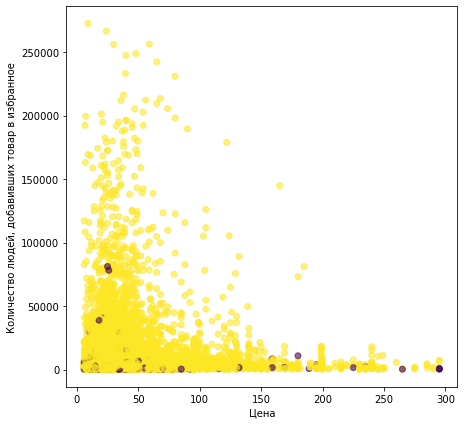

In [47]:
plt.figure(figsize=(7,7))
plt.scatter(X_train['price'], X_train['love'], c=y_train, alpha=0.6)
plt.xlabel('Цена')
plt.ylabel('Количество людей, добавивших товар в избранное')

In [48]:
def best_results(model, params):
    pipeline=Pipeline(steps=[('scaler', StandardScaler()), ('model', model)])
    clf = GridSearchCV(pipeline, params, scoring='f1', refit=True, n_jobs=-1)
    return(clf)

In [94]:
model=KNeighborsClassifier()
clf=best_results(model, {'model__n_neighbors': list(range(2, 8))})
clf.fit(X_train, y_train)
preds=clf.best_estimator_.predict(X_test)
print('Для тестовой выборки:')
print(confusion_matrix(y_test, preds), '\n', clf.best_score_, '\n', 'лучшие гиперпараметры: ', clf.best_params_)
print('Для тренировочной выборки')
preds=clf.best_estimator_.predict(X_train)
print(confusion_matrix(y_train, preds), '\n', f1_score(y_train, preds), '\n', 'лучшие гиперпараметры: ', clf.best_params_)

Для тестовой выборки:
[[   2  136]
 [   6 2449]] 
 0.9218881739945275 
 лучшие гиперпараметры:  {'model__n_neighbors': 7}
Для тренировочной выборки
[[  13  304]
 [   8 5724]] 
 0.9734693877551021 
 лучшие гиперпараметры:  {'model__n_neighbors': 7}


Ошибки и матрицы соответствий непоказательны в случае сильного дисбаланса классов

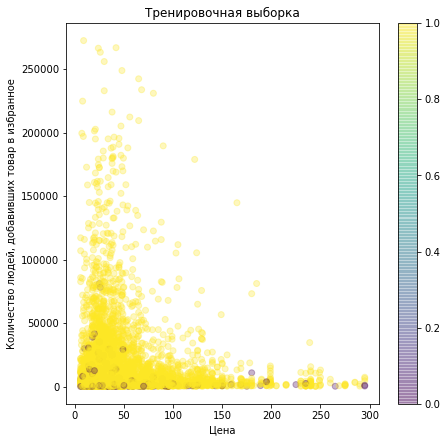

In [199]:
plt.figure(figsize=(7,7))
plt.scatter(X_train['price'], X_train['love'], c=y_train, alpha=0.3)
plt.xlabel('Цена')
plt.ylabel('Количество людей, добавивших товар в избранное')
plt.title('Тренировочная выборка')
plt.colorbar()

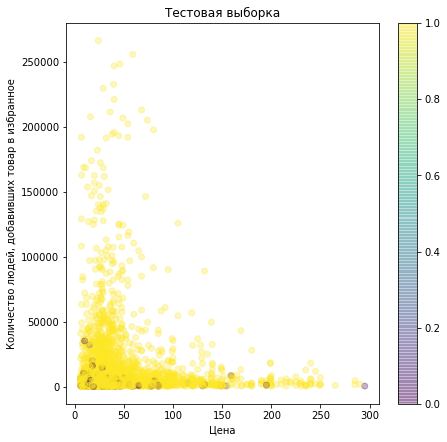

In [200]:
plt.figure(figsize=(7,7))
plt.scatter(X_test['price'], X_test['love'], c=y_test, alpha=0.3)
plt.xlabel('Цена')
plt.ylabel('Количество людей, добавивших товар в избранное')
plt.title('Тестовая выборка')
plt.colorbar()

Из-за расположения точек метод k ближайших соседей не может классифицировать обьекты класса 0 правильно. Возможно, нужно учитывать составы продуктов? (чтобы было больше различий между классами) 

In [201]:
model=RandomForestClassifier()
clf=best_results(model, {'model__max_depth': list(range(2, 20)), 'model__n_estimators' : list(range(10, 200, 30))})
clf.fit(X_train, y_train)
preds=clf.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, preds), '\n', clf.best_score_,'\n', 'лучшие гиперпараметры: ', clf.best_params_)

[[   0  132]
 [   0 2461]] 
 0.9725690001630916 
 лучшие гиперпараметры:  {'model__max_depth': 2, 'model__n_estimators': 10}


In [119]:
model=DecisionTreeClassifier()
clf=best_results(model, {'model__max_depth': list(range(1, 20))})
clf.fit(X_train, y_train)
preds=clf.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, preds), '\n', clf.best_score_, '\n', 'лучшие гиперпараметры: ', clf.best_params_)

[[   0  140]
 [   0 2453]] 
 0.9739631752733485 
 лучшие гиперпараметры:  {'model__max_depth': 1}


В силу дисбаланса классов с точки зрения классификатора самым выгодным будет отнести все объекты к классу 1, поэтому нужно попробовать балансировку (для 2 классов уже больше возможностей)

# RandomOverSampling

In [97]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

model=KNeighborsClassifier()
clf=best_results(model, {'model__n_neighbors': list(range(2, 10))})
clf.fit(X_resampled, y_resampled)
preds=clf.best_estimator_.predict(X_test)
print('тестовая выборка')
print(confusion_matrix(y_test, preds), '\n', clf.best_score_, '\n', clf.best_params_)
print('тренировочная выборка')
preds=clf.best_estimator_.predict(X_resampled)
print(confusion_matrix(y_resampled, preds), '\n','f1 на тренировочной выборке: ', f1_score(y_resampled, preds), '\n', 'лучшие гиперпараметры: ', clf.best_params_)

[(0, 5732), (1, 5732)]
тестовая выборка
[[  36  102]
 [ 239 2216]] 
 0.943909582386653 
 {'model__n_neighbors': 2}
тренировочная выборка
[[5732    0]
 [ 303 5429]] 
 f1 на тренировочной выборке:  0.9728518949914883 
 лучшие гиперпараметры:  {'model__n_neighbors': 2}


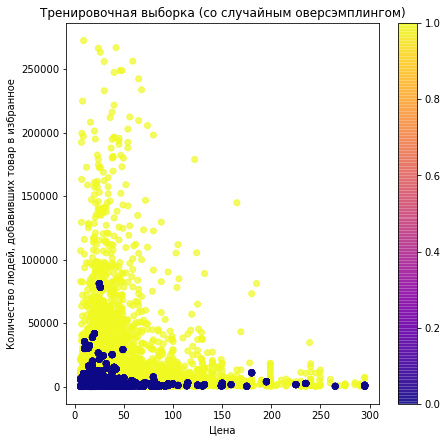

In [239]:
plt.figure(figsize=(7,7))
plt.scatter(X_resampled['price'], X_resampled['love'], c=y_resampled, alpha=0.7
            , cmap='plasma')
plt.xlabel('Цена')
plt.ylabel('Количество людей, добавивших товар в избранное')
plt.title('Тренировочная выборка (со случайным оверсэмплингом)')
plt.colorbar()

Видно, что в тренировочной выборке появилось больше представителей класса 0, сосредоточенных в одной области. Точки жирные, поскольку RandomOverSampler просто копирует объекты, отсюда может быть и не сильно улучшившаяся точность классификации

In [148]:
model=RandomForestClassifier()
clf=best_results(model, {'model__max_depth': list(range(2, 20)), 'model__n_estimators' : list(range(10, 200, 30))})
clf.fit(X_train, y_train)
preds=clf.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, preds), '\n', clf.best_score_,'\n', 'лучшие гиперпараметры: ', clf.best_params_)

[[   2  138]
 [   2 2451]] 
 0.9742937373974329 
 лучшие гиперпараметры:  {'model__max_depth': 8, 'model__n_estimators': 100}


Аналогично нулевой класс не выделяется

In [96]:
model=GradientBoostingClassifier()
clf=best_results(model, {'model__n_estimators': list(range(100, 250, 10))})
clf.fit(X_resampled, y_resampled)
preds=clf.best_estimator_.predict(X_test)
print('тестовая выборка')
print(confusion_matrix(y_test, preds), '\n','f1 на тестовой выборке: ', clf.best_score_, '\n', 'лучшие гиперпараметры: ', clf.best_params_)
print('тренировочная выборка')
preds=clf.best_estimator_.predict(X_resampled)
print(confusion_matrix(y_resampled, preds), '\n','f1 на тренировочной выборке: ', f1_score(y_resampled, preds), '\n', 'лучшие гиперпараметры: ', clf.best_params_)

тестовая выборка
[[  71   67]
 [ 534 1921]] 
 f1 на тестовой выборке:  0.8530872774567791 
 лучшие гиперпараметры:  {'model__n_estimators': 240}
тренировочная выборка
[[5313  419]
 [1067 4665]] 
 f1 на тренировочной выборке:  0.8626109467455623 
 лучшие гиперпараметры:  {'model__n_estimators': 240}


Хоть ошибка особо не изменилась, точность предсказания на тренировочной выборке сильно лучше, чем на тестовой, при этом она не близка к 1

# SMOTE, 2 соседа

In [278]:
ros = SMOTE(k_neighbors = 2, random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 5723), (1, 5723)]


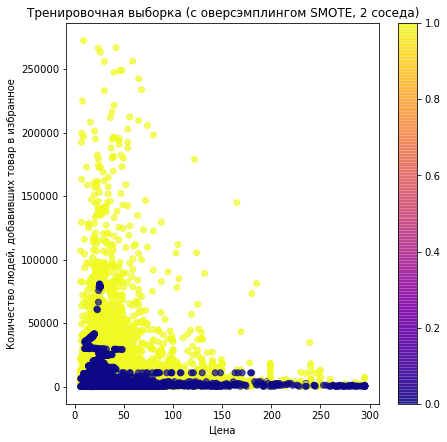

In [246]:
plt.figure(figsize=(7,7))
plt.scatter(X_resampled['price'], X_resampled['love'], c=y_resampled, alpha=0.7
            , cmap='plasma')
plt.xlabel('Цена')
plt.ylabel('Количество людей, добавивших товар в избранное')
plt.title('Тренировочная выборка (с оверсэмплингом SMOTE, 2 соседа)')
plt.colorbar()

In [206]:
model=KNeighborsClassifier()
clf=best_results(model, {'model__n_neighbors': list(range(1, 10))})
clf.fit(X_resampled, y_resampled)
preds=clf.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, preds), '\n', clf.best_score_, '\n', clf.best_params_)

[[  28  104]
 [ 156 2305]] 
 0.9304683821370832 
 {'model__n_neighbors': 3}


In [242]:
model=RandomForestClassifier()
clf=best_results(model, {'model__max_depth': list(range(2, 20)), 'model__n_estimators' : list(range(10, 200, 30))})
clf.fit(X_train, y_train)
preds=clf.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, preds), '\n', clf.best_score_,'\n', 'лучшие гиперпараметры: ', clf.best_params_)

[[   0  121]
 [   0 2472]] 
 0.9725551406626309 
 лучшие гиперпараметры:  {'model__max_depth': 8, 'model__n_estimators': 70}


In [279]:
model=GradientBoostingClassifier()
clf=best_results(model, {'model__n_estimators': list(range(100, 250, 10))})
clf.fit(X_resampled, y_resampled)
preds=clf.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, preds), '\n','f1 на тестовой выборке: ', clf.best_score_, '\n', 'лучшие гиперпараметры: ', clf.best_params_)

[[  15  106]
 [  88 2384]] 
 f1 на тестовой выборке:  0.9295148677342588 
 лучшие гиперпараметры:  {'model__n_estimators': 240}


Посмотрим еще на распределения для разного числа соседей:

# SMOTE, 3 соседа

In [275]:
ros = SMOTE(k_neighbors = 3, random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 5723), (1, 5723)]


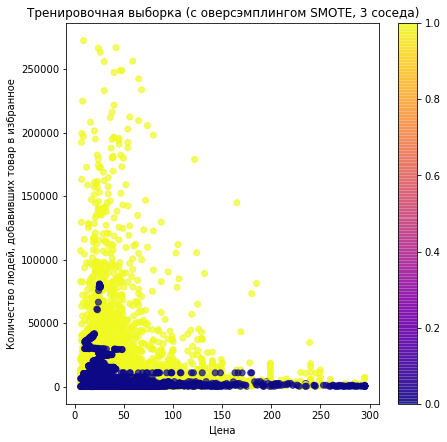

In [248]:
plt.figure(figsize=(7,7))
plt.scatter(X_resampled['price'], X_resampled['love'], c=y_resampled, alpha=0.7
            , cmap='plasma')
plt.xlabel('Цена')
plt.ylabel('Количество людей, добавивших товар в избранное')
plt.title('Тренировочная выборка (с оверсэмплингом SMOTE, 3 соседа)')
plt.colorbar()

In [276]:
model=KNeighborsClassifier()
clf=best_results(model, {'model__n_neighbors': list(range(1, 10))})
clf.fit(X_resampled, y_resampled)
preds=clf.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, preds), '\n', clf.best_score_, '\n', clf.best_params_)

[[  29   92]
 [ 211 2261]] 
 0.9207687859044139 
 {'model__n_neighbors': 1}


In [277]:
model=GradientBoostingClassifier()
clf=best_results(model, {'model__n_estimators': list(range(100, 250, 10))})
clf.fit(X_resampled, y_resampled)
preds=clf.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, preds), '\n','f1 на тестовой выборке: ', clf.best_score_, '\n', 'лучшие гиперпараметры: ', clf.best_params_)

[[  18  103]
 [  74 2398]] 
 f1 на тестовой выборке:  0.9250300601827315 
 лучшие гиперпараметры:  {'model__n_estimators': 240}


# SMOTE, 4 соседа

In [274]:
ros = SMOTE(k_neighbors = 4, random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 5723), (1, 5723)]


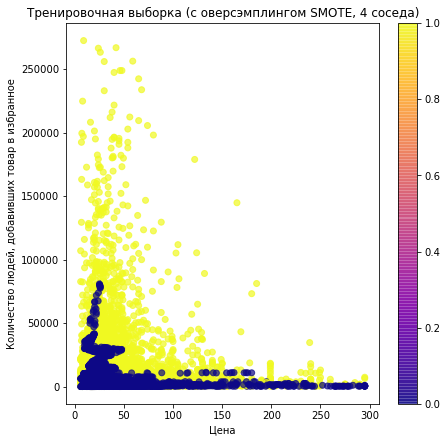

In [267]:
plt.figure(figsize=(7,7))
plt.scatter(X_resampled['price'], X_resampled['love'], c=y_resampled, alpha=0.7
            , cmap='plasma')
plt.xlabel('Цена')
plt.ylabel('Количество людей, добавивших товар в избранное')
plt.title('Тренировочная выборка (с оверсэмплингом SMOTE, 4 соседа)')
plt.colorbar()

In [268]:
model=KNeighborsClassifier()
clf=best_results(model, {'model__n_neighbors': list(range(1, 10))})
clf.fit(X_resampled, y_resampled)
preds=clf.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, preds), '\n', clf.best_score_, '\n', clf.best_params_)

[[  28   93]
 [ 209 2263]] 
 0.9199985877561468 
 {'model__n_neighbors': 1}


In [273]:
model=GradientBoostingClassifier()
clf=best_results(model, {'model__n_estimators': list(range(100, 250, 10))})
clf.fit(X_resampled, y_resampled)
preds=clf.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, preds), '\n','f1 на тестовой выборке: ', clf.best_score_, '\n', 'лучшие гиперпараметры: ', clf.best_params_)

[[  18  103]
 [  86 2386]] 
 f1 на тестовой выборке:  0.9219029359161734 
 лучшие гиперпараметры:  {'model__n_estimators': 240}


# 12. Итоги

Была проведена предобработка данных, запущены разные алгоритмы классификации на 9 классах, попытка балансировки 9 классов, затем приведение к задаче бинарной классификации и применение аналогичных алгоритмов на ней.

1. Неудаление некоторых признаков не привело бы к улучшению результата, так как они совершенно не характеризуют различия между классами
2. Хотелось бы включить в набор признаков ингредиенты, пока не совсем понятно, как это реализовать (методы NLP?)
3. Модели недообучаются, их нужно усложнять (при несбалансированных классах)
4. Дисбаланс классов очень сильно влияет: лучше всего себя показал градиентный бустинг со случайным сэмплированием.
5. Сильно коррелированных признаков нет (кроме love и number_of_reviews, но второй был удалён)
6. Данных недостаточно для определения различий между классами?
7. По диаграмме рассеивания видно, что нет чётких границ между областями классов, отсюда метод ближайших соседей не показал хороших результатов
8. На выборке после балансировки метод ближайших соседей и градиентный бустинг работают по-разному: первый делает много ложных предсказаний класса 0, в то время как второй отдаёт предпочтение классу 1
9. Возможно, задачу стоит рассматривать как детектирование аномалий?
10. Можно так же решить задачу регресии (предсказание цены)